# Revisiting the Titanic

## 1. Introduction

The Titanic dataset is often used as an introductory Data Science example, with the goal usually to predict whether a particular passenger survives or not based upon the features present in the data, such as name, age or whether they have a sibling/spouse or parents/children. The beginner tutorials serve as a nice introduction to simple data cleaning, feature engineering and model fitting, however in all examples I witnessed the data points were always being treated as independently distributed. This is often a valid assumption in supervised learning practices but in this case it is clearly violated - many passengers are related to each other or are traveling in a group, which naturally motivates the question.

*Are the chances of a passenger surviving affected if one or more members in the rest of their group survive?*

In this article, rather than following the usual prediction problem route, I intend to address this question using both classical and Bayesian Hypothesis testing and discuss the differences between the two. More specifically, I will take $p^*$ to be the probability of single passengers (those traveling on their own) surviving, and test the following two alternative hypotheses to see if we do indeed have a significant effect.

1. The survival probability $p_1$ of a passenger with a least one other surviving member of their group is greater than $p^*$
2. The survival probability $p_2$ of a passenger who does not have any surviving members of their group is less than $p^*$

The code for this notebook can be found [here](https://profile.chrisjoyner.uk/blog/titanic/files/titanic_notebook.ipynb)

## 2. Importing and separating datasets

The first step is to separate out the various passengers. For convenience, we use the full Titanic dataset, which can be found [here](https://github.com/alexisperrier/packt-aml/blob/master/ch4/original_titanic.csv), rather than the more common version that has already been split into train and test parts. This is because passengers in the train set may be related to those in the test set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load Titanic datset
cols = ['Survived', 'Name', 'SibSp', 'Parch', 'Ticket']
df = pd.read_csv('Datasets/full_titanic.csv', usecols=cols)
df['PassengerId'] = df.index.values

We separate the groups based upon ticket number and surname, so must therefore extract the surname from the entries in the name column.

In [3]:
def get_surname_title(name):

    """
    input: name in format 'surname, title. firstnames'

    returns: surname, title, firstnames
    """
    names = name.split(', ')
    surname = names[0]
    other_names = names[1].split('.')    
    return surname, other_names[0], other_names[1]

# Extract surname and titles
name_values = df['Name'].apply(get_surname_title).values
df['Surname'], df['Title'], df['Firstname'] = list(zip(*name_values))

The next step is to remove all the single passengers, which we identify as all those without a Sibling/Spouse or a Parent/Child.

The Titanic dataset does contain errors so we are unlikely to obtain exactly the right separations, however it is better to first get a rough approximation of our results rather than undertake a time consuming cleaning process only to find we don't get the answer we are hoping.

In [5]:
# Separate single and grouped passengers
single_records = (df['SibSp']==0) & (df['Parch']==0)
df_single = df[single_records].copy()
df_group = df[~single_records]

`df_single` will be kept for later, whereas within `df_group` we will identify the family group each passenger belongs to. The first method is grouping by ticket number, however a cursory look over the data shows there are some families whose ticket numbers are close but not exact. We will therefore make sure the group size is correct by comparing against the number of sibling/spouse/parent/child.

In [6]:
# Group passengers with same ticket
ticket_grouping = df_group[['PassengerId', 'Ticket']].groupby(by='Ticket').count().reset_index()
ticket_grouping = ticket_grouping.rename(columns={'PassengerId': 'TicketGroupSize'})

# Give a number (Id) to each group
n_groups = ticket_grouping.shape[0]
ticket_grouping['GroupNumber'] = list(range(0, n_groups))

# Assign that GroupNumber to each passenger
df_group = df_group.merge(ticket_grouping, how='left', on='Ticket')

# Split df_group into A those with correct group size and B those without
records = (df_group['SibSp'] + df_group['Parch']) == (df_group['TicketGroupSize'] - 1)
df_A = df_group[records]
df_B = df_group[~records].drop(columns='GroupNumber')

The remaining groups we attempt to pick out by grouping by surname. This time we don't compare to sibling/spouse/parent/child but simply discard any groups of size 1.

In [7]:
# Groups the remainder by surname
surname_grouping = df_B[['PassengerId', 'Surname']].groupby(by='Surname').count().reset_index()
surname_grouping = surname_grouping.rename(columns={'PassengerId': 'SurnameGroupSize'})

# Discard any groups of size 1
surname_grouping = surname_grouping[surname_grouping['SurnameGroupSize']>1]

# Give a number (Id) to each group
m_groups = surname_grouping.shape[0]
surname_grouping['GroupNumber'] = list(range(n_groups, n_groups+m_groups))

# Assign that GroupNumber to each passenger
df_B = df_B.merge(surname_grouping, how='right', on='Surname')

We create a final data frame `df_final` by concatenating the ticketed and surnamed data frames and dropping/renaming suitable columns. We also renumber the group numberings for consistency.

In [8]:
# Combine A and B dataframes
df_final = pd.concat((df_A, df_B), axis=0)
df_final = df_final.drop(columns=['SibSp', 'Parch'])

# Combine SurnameGroupSize and TicketGroupSize into a single column GroupSize
df_final['GroupSize'] = np.where(df_final['SurnameGroupSize'].isna(), df_final['TicketGroupSize'], df_final['SurnameGroupSize'])
df_final = df_final.drop(columns=['TicketGroupSize', 'SurnameGroupSize'])
df_final = df_final.sort_values(by='GroupNumber').reset_index(drop=True)

# Relabel the group numberings as some were removed in previous cell
group_numberings = df_final['GroupNumber'].unique()
df_final['GroupNumber'] = df_final['GroupNumber'].replace(dict(zip(group_numberings, list(range(0, len(group_numberings))))))

The final step is to determine how many of each group survive and use that to create the feature of how many other passengers in the group survived for each passenger.

In [9]:
# Determine how many of each group survive
summation = df_final[['GroupNumber', 'Survived']].groupby(by='GroupNumber').sum().reset_index()
summation = summation.rename(columns={'Survived': 'GroupTotalSurvived'})

# Specify for each passenger how many other passengers in their group survive
df_final = df_final.merge(summation, how='left', on='GroupNumber')
df_final['GroupTotalSurvived'] = df_final['GroupTotalSurvived'] - df_final['Survived']

## 3. Classical hypothesis testing

We are now in a position to test our hypotheses. Firstly, we label the three groups we are interested in, namely the `Single` passengers, those non-single passengers with at least one surviving group member (`Yes survived`) and those non-single passengers without (`No survived`), which are combined into a single data frame.

In [10]:
# Label the groups
df_single['GroupSurvived'] = 'Single'
df_final['GroupSurvived'] = np.where(df_final['GroupTotalSurvived'] > 0, 'Yes survived', 'No survived')

# Combine and 
df_hyp = pd.concat((
    df_single[['Survived', 'GroupSurvived']],
    df_final[['Survived', 'GroupSurvived']]
), axis=0)

df_hyp['GroupSurvived'] = df_hyp['GroupSurvived'].astype('category')

Grouping by the different labels gives us the parameters necessary for our tests.

In [11]:
totals = df_hyp.groupby(by='GroupSurvived').count().rename(columns={'Survived': 'Total'})

hypothesis = df_hyp.groupby(by='GroupSurvived').sum()
hypothesis = pd.concat((hypothesis, totals), axis=1)
hypothesis['Proportion'] = (hypothesis['Survived']/hypothesis['Total']).round(3)

hypothesis

,Survived,Total,Proportion
GroupSurvived,,,
No survived,56,228,0.246
Single,239,790,0.303
Yes survived,188,268,0.701


Our reference value is the proportion of surviving single passengers, given by $p^* = 0.303$.

Our first alternative hypothesis is that $p_1$ (the proportion of `Yes survived`) is greater than $p^*$. The table suggests this is correct but our hypothesis test aims to determine whether that is simply down to chance or if it is significant. We therefore ask what the proportion of surviving passengers would be if we randomly draw 268 samples in which the probability of survival is $p^* = 0.303$. The distribution of that proportion is given by a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), whose density function can be found within the `scipy.stats` package.

*Note: Strictly speaking the binomial distribution is correct if the samples are independent, which, as discussed, does not hold in our case. We could feasibly assume independence across different groups and so create a more accurate result by randomly sampling groups of different sizes and then sampling from within groups. Since this is meant to be a simple illustration I will leave that to someone else...*

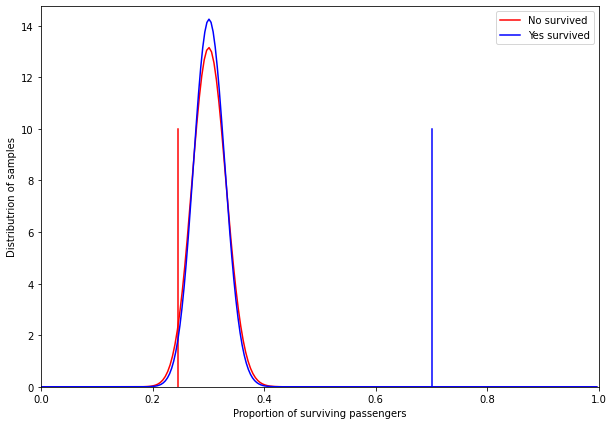

In [12]:
import scipy.stats as ss

p_star = hypothesis.loc['Single', 'Proportion']

colors = {
    'No survived': 'red',
    'Yes survived': 'blue'
}

max_y = 0
plt.figure(figsize=(10, 7))

# Plot distributions under the null hypothesis and associated proportions
for label, outcome in hypothesis.drop('Single').iterrows():
    
    n = outcome['Total']
    p = outcome['Proportion']

    x = np.arange(0, n+1)
    y = (n+1)*ss.binom.pmf(x, n, p_star)

    max_y = np.max(y) if np.max(y) > max_y else max_y

    plt.plot(x/(n+1), y, color=colors[label], label=label)
    plt.plot([p, p], [0, 10], color=colors[label])

plt.xlim(0, 1)
plt.ylim(0, max_y+0.5)
plt.xlabel('Proportion of surviving passengers')
plt.ylabel('Distribution of samples')
plt.legend()

The above figure shows the distribution visually. In both cases we have specified a one-sided hypothesis, so for `Yes survived` we want the probability that the blue distribution is greater than $p_1 = 0.701$ (the blue vertical line) and for `No survived` the probability the red distribution is less than $p_2 = 0.246$ (the red vertical line). These calculation are below.

In [13]:
for label, outcome in hypothesis.drop('Single').iterrows():
    
    n = outcome['Total']
    m = outcome['Survived']
    
    p_val = ss.binom.cdf(m, n, p_star)

    if label == 'Yes survived':
        p_val = 1 - p_val

    
    print(f'{label} p-value:', p_val)

No survived p-value: 0.03302366921840849
Yes survived p-value: 1.1102230246251565e-16


Usually a reference value of 0.05 is chosen, whereby a p-value less than 0.05 leads to rejecting the null hypothesis, whereas with a p-value more than 0.05 we cannot. In this instance both values are below 0.05, suggesting the chances that are results are due to random fluctuations under the null hypothesis are very low.

## 4. Bayesian hypothesis testing

Unfortunately, there is often confusion about what the p-value represents. It is *not* the probability that the null hypothesis is true or false but the probability of an event occuring (in the above case the value being above or below a threshold value) under the assumption that the null hypothesis is correct, which is similar but subtly different.

To illustrate the difference we now take a Bayesian approach to hypothesis testing, inspired by a [simple Bayesian Hypothesis testing example](https://www.youtube.com/watch?v=s4yCu__18Jo) by Norman Fenton.

In the Bayesian setup we are interested directly in the probability $P(H|D)$ of a hypothesis $H$ being true or false under our observations $D$. Referring back to the introduction $H_1$ is true if $p_1 > p^*$ and $H_2$ is true if $p_2 < p^*$. Here $p^* = 0.303$ is our threshold value discovered earlier. In our case our data $D$ consists of $n$ the total number of passengers and $k$ the number of surviving passengers. Like before, the probability $P(k|n,p)$ of observing $k$ for a particular $p$ (the underlying probability of survival) is given by the Binomial distribution, however we are really after $\rho(p | n, k)$ - the distribution of getting $p$ given our data $k, n$. Using Bayes' theorem this can be expressed as
$$
\rho(p|k,n) = \frac{P(k,n|p)\rho(p)}{P(k,n)},
$$
where
$$
P(k,n) = \int_{0}^1  P(k,n|p)\rho(p) dp .
$$
This formulation requires us to choose a **prior distribution** $\rho(p)$ that represents our current belief (before observation) of the value for $p$. This is considered by many as a disadvantage of the Bayesian approach, as it requires imposing exterior information on to the problem, rather than following a set-procedure that only uses internal information.

A natural choice for the form of $\rho(p)$ is the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), which is a so-called [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) for the binomial distribution, meaning the posterior $\rho(p|k,n)$ is guaranteed to also be beta distributed. More specifically, if $\rho(p)$ takes the form
$$
\rho_{a, b}(p) := \frac{p^{a-1}(1-p)^{b-1}}{B(a,b)},
$$
with $a$ and $b$ free parameters (up to suitable constraints which I won't go in to) and $B(a,b)$ is the [Beta function](https://en.wikipedia.org/wiki/Beta_function) then $\rho(p|k,n)$ is also beta-distributed with parameters $a+k$ and $b + (n-k)$.

This leaves us with a choice for $a$ and $b$. Since we have very limited knowledge we can assume that each outcome $p$ is equally likely. This corresponds to taking $a=1$ and $b=1$, meaning the beta distribution takes the form uniform distribution over the interval $[0, 1]$. The associated prior and subsequent posterior distributions for both `No survived` and `Yes survived` are plotted below.

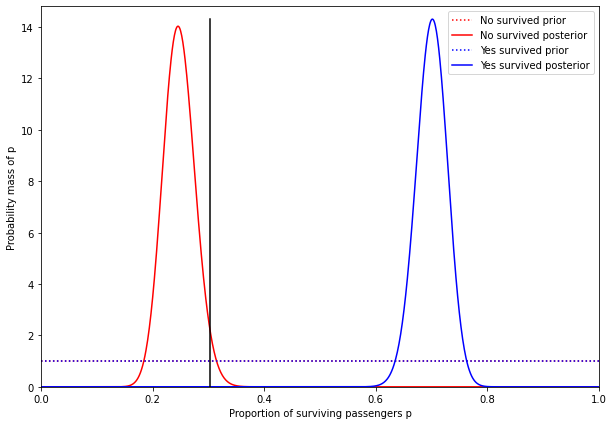

In [14]:
# Prior parameters
a_prior = 1
b_prior = 1

p_star = hypothesis.loc['Single', 'Proportion']

colors = {
    'No survived': 'red',
    'Yes survived': 'blue'
}

plt.figure(figsize=(10, 7))

x = np.linspace(0, 1, 1000)
max_y = 0

for label, outcome in hypothesis.drop('Single').iterrows():
    
    n = outcome['Total']
    k = outcome['Survived']

    # Posterior parameters
    a_post = a_prior + k
    b_post = b_prior + (n-k)

    # Prior/Posterior distributions
    y_prior = ss.beta.pdf(x, a_prior, b_prior)
    y_post = ss.beta.pdf(x, a_post, b_post)

    max_y = np.max(y_post) if np.max(y_post) > max_y else max_y

    # Prior/Posterior plots
    plt.plot(x, y_prior, color=colors[label], linestyle='dotted', label=f'{label} prior')
    plt.plot(x, y_post, color=colors[label], label=f'{label} posterior')

plt.plot([p_star, p_star], [0, max_y], color='black')

plt.xlim(0, 1)
plt.ylim(0, max_y+0.5)
plt.xlabel('Proportion of surviving passengers p')
plt.ylabel('Probability mass of p')
plt.legend()


Note, in particular, the distributions are centred around the observed proportions, rather than our reference value $p^*$, as in the classical scenario, which highlights the viewpoints of each methodology. In general, if the distributions here were symmetric and matched those in the classical case, just with their centres shifted to $p^*$, then the p-values (or rather 1 minus the p-values) would match our Bayesian probabilities we calculate below. However that is not the case here (the binomial distribution is discrete, whereas the beta distribution is continuous for a start).

The probability of each hypothesis being true/false is then given by integrating the appropraite distribution up to the reference value $p^*$. Mathematically, therefore, we have $P(H_1 | D)$ given by
$$
P(p_1 > p^* | k, n) = \int_{p^*}^1 \rho(p | k, n) dp
$$
and, similarly, $P(H_2 | D)$ by
$$
P(p_2 < p^* | k, n) = \int_{0}^{p^*} \rho(p | k, n) dp
$$
which we calculate using the cumulative distribution functions below

In [17]:
for label, outcome in hypothesis.drop('Single').iterrows():
    
    n = outcome['Total']
    k = outcome['Survived']

    a_post = a_prior + k
    b_post = b_prior + (n-k)
    
    p_hyp = ss.beta.cdf(p_star, a_post, b_post)

    if label == 'Yes survived':
        p_hyp = 1 - p_hyp

    print(f"The probability of '{label}' is {p_hyp}")

The probability of 'No survived' is 0.9698958524328247
The probability of 'Yes survived' is 1.0


## 5. Conclusions

We have identified the possibility of non-independent data points in the Titanic dataset, hypothesising that the survival (or not) of members of the same travelling group would have an effect on the passenger survival. We investigated these hypotheses from both a classical and Bayesian perspective and discussed the differences, advantages and disadvantages. Both methodologies showed convincingly our suspicions were correct, although a more thorough investigations of our independence assumptions is likely required.

It would be interesting to see how this data can be utilised to make better predictions about passenger survival probability. For instance, combining other features like age, sex and group size to refine the status of each group member and improving the data cleaning to identify groups more accurately.